In [20]:
import datasets
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from tqdm import tqdm


colab = True

In [21]:
dataset = datasets.load_dataset('tweets_hate_speech_detection', cache_dir=None)

dataset_train = dataset['train'].select(range(len(dataset['train']) // 8))

split_dataset = dataset_train.train_test_split(test_size=0.2, seed=42)

dataset = split_dataset

display(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 3196
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 799
    })
})

In [22]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:
def split_tokens(row):
    text = row['tweet']

    tokens = word_tokenize(text.lower())

    row['tokens'] = tokens
    return row

In [24]:
dataset = dataset.map(split_tokens)
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'tokens'],
        num_rows: 3196
    })
    test: Dataset({
        features: ['label', 'tweet', 'tokens'],
        num_rows: 799
    })
})

In [25]:
all_tokens = []

for tokens in dataset['train']['tokens']:
  all_tokens.extend(tokens)

display(len(all_tokens))

vocab = list(set(all_tokens))
vocab[100:120]

58005

['girlsnightoutâ\x80¦',
 'increased',
 'usofa',
 'babe',
 'trash',
 'carlpalladino',
 'sms',
 'upgraded',
 'giftideas',
 'coward',
 't-shi',
 'lifeisgood',
 'mission',
 'ã\x83\x87ã\x82£ã\x82ºã\x83\x8bã\x83¼',
 'multiculturalism',
 'handsome',
 'quoteoftheday',
 'exams.ð\x9f\x98¯',
 'babilicious',
 'sdl326am']

In [26]:
token2id = {token: idx for idx, token in enumerate(vocab)}
id2token = {idx: token for idx, token in enumerate(vocab)}

In [27]:
def sliding_window(row):
  window_size = 2

  doc = row['tokens']
  out = []

  for i, token in enumerate(doc):
    target = token2id[token]

    aux = []

    for j in range(-window_size, window_size+1): # -2, -1, 0, 1, 2
      index = i + j

      if index < 0 or index >= len(doc) or j == 0:
        continue

      aux.append((target, token2id[doc[index]]))

    out.extend(aux)

  row['window'] = out

  return row

In [28]:
dataset = dataset['train'].map(sliding_window)

In [29]:
class Word2VecDataset(Dataset):
    def __init__(self, dataset):
        self.data = []

        for row in dataset:
            self.data.extend(row['window'])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [30]:
my_dataset = Word2VecDataset(dataset)
len(my_dataset)

212844

In [40]:
dataloader = DataLoader(my_dataset, batch_size=128, shuffle=True)

In [41]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.expand = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        embed_vector = self.embed(x)
        output = self.expand(embed_vector)

        return output
    

In [42]:
network = Word2Vec(len(vocab), 5)

In [43]:
LR = 0.01
EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(network.parameters(), lr=LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)


Word2Vec(
  (embed): Embedding(10062, 5)
  (expand): Linear(in_features=5, out_features=10062, bias=True)
)

In [44]:
from datetime import datetime
import os

today = datetime.now().strftime("%Y-%m-%d")
os.makedirs(f'models/{today}', exist_ok=True)

all_losses = []

for i in range(EPOCHS):
    epoch_loss = 0

    for input, context in tqdm(dataloader):
        input = input.to(device)
        context = context.to(device)

        output = network(input)

        optimizer.zero_grad()

        loss = loss_fn(output, context) # saber quanto erramoszes
        epoch_loss += loss.item() / len(dataloader) # monitorar as losszes

        loss.backward() # calcula os gradientes
        optimizer.step() # atualiza os pesos

    torch.save(network.state_dict(), f'models/{today}/word2vec-{i}.pt')

    all_losses.append(epoch_loss)
    print(f"Epoch {i} loss: {epoch_loss}")

100%|██████████| 1663/1663 [00:02<00:00, 704.76it/s]


Epoch 0 loss: 6.703018234640602


100%|██████████| 1663/1663 [00:02<00:00, 729.99it/s]


Epoch 1 loss: 6.128944374894204


100%|██████████| 1663/1663 [00:02<00:00, 628.28it/s]


Epoch 2 loss: 6.016642065271865


100%|██████████| 1663/1663 [00:02<00:00, 726.49it/s]


Epoch 3 loss: 5.955835544554083


100%|██████████| 1663/1663 [00:02<00:00, 728.31it/s]


Epoch 4 loss: 5.919337500596863


100%|██████████| 1663/1663 [00:02<00:00, 735.71it/s]


Epoch 5 loss: 5.896362478734493


100%|██████████| 1663/1663 [00:02<00:00, 713.58it/s]


Epoch 6 loss: 5.882200041522623


100%|██████████| 1663/1663 [00:02<00:00, 633.76it/s]


Epoch 7 loss: 5.872523833668813


100%|██████████| 1663/1663 [00:02<00:00, 729.79it/s]


Epoch 8 loss: 5.865480359318883


100%|██████████| 1663/1663 [00:02<00:00, 723.53it/s]


Epoch 9 loss: 5.860405861722074


100%|██████████| 1663/1663 [00:02<00:00, 727.18it/s]


Epoch 10 loss: 5.856997813650868


100%|██████████| 1663/1663 [00:02<00:00, 731.83it/s]


Epoch 11 loss: 5.854338853529823


100%|██████████| 1663/1663 [00:02<00:00, 627.25it/s]


Epoch 12 loss: 5.852106481450051


100%|██████████| 1663/1663 [00:02<00:00, 719.70it/s]


Epoch 13 loss: 5.850281996391507


100%|██████████| 1663/1663 [00:02<00:00, 725.38it/s]


Epoch 14 loss: 5.849150247625465


100%|██████████| 1663/1663 [00:02<00:00, 713.61it/s]


Epoch 15 loss: 5.84804467558502


100%|██████████| 1663/1663 [00:02<00:00, 708.51it/s]


Epoch 16 loss: 5.846712932196714


100%|██████████| 1663/1663 [00:02<00:00, 636.55it/s]


Epoch 17 loss: 5.846416672954908


100%|██████████| 1663/1663 [00:02<00:00, 720.80it/s]


Epoch 18 loss: 5.845764460079085


100%|██████████| 1663/1663 [00:02<00:00, 718.03it/s]


Epoch 19 loss: 5.844507938254266


100%|██████████| 1663/1663 [00:02<00:00, 725.01it/s]


Epoch 20 loss: 5.8441496139108775


100%|██████████| 1663/1663 [00:02<00:00, 697.00it/s]


Epoch 21 loss: 5.844025529011571


100%|██████████| 1663/1663 [00:02<00:00, 646.20it/s]


Epoch 22 loss: 5.843231120313151


100%|██████████| 1663/1663 [00:02<00:00, 727.40it/s]


Epoch 23 loss: 5.843253712301438


100%|██████████| 1663/1663 [00:02<00:00, 736.25it/s]


Epoch 24 loss: 5.842967040841287


100%|██████████| 1663/1663 [00:02<00:00, 729.27it/s]


Epoch 25 loss: 5.842127022080874


100%|██████████| 1663/1663 [00:02<00:00, 707.55it/s]


Epoch 26 loss: 5.841800404397821


100%|██████████| 1663/1663 [00:02<00:00, 639.85it/s]


Epoch 27 loss: 5.842392252499415


100%|██████████| 1663/1663 [00:02<00:00, 724.37it/s]


Epoch 28 loss: 5.841655075442555


100%|██████████| 1663/1663 [00:02<00:00, 730.33it/s]


Epoch 29 loss: 5.841688534902361


100%|██████████| 1663/1663 [00:02<00:00, 728.13it/s]


Epoch 30 loss: 5.841204177594941


100%|██████████| 1663/1663 [00:02<00:00, 700.17it/s]


Epoch 31 loss: 5.84155589388711


100%|██████████| 1663/1663 [00:02<00:00, 651.35it/s]


Epoch 32 loss: 5.841217737777083


100%|██████████| 1663/1663 [00:02<00:00, 720.01it/s]


Epoch 33 loss: 5.841284607665338


100%|██████████| 1663/1663 [00:02<00:00, 724.10it/s]


Epoch 34 loss: 5.841372845764985


100%|██████████| 1663/1663 [00:02<00:00, 729.01it/s]


Epoch 35 loss: 5.840594111905351


100%|██████████| 1663/1663 [00:02<00:00, 693.19it/s]


Epoch 36 loss: 5.840994088246889


100%|██████████| 1663/1663 [00:02<00:00, 646.60it/s]


Epoch 37 loss: 5.84107253584458


100%|██████████| 1663/1663 [00:02<00:00, 727.56it/s]


Epoch 38 loss: 5.839818781854445


100%|██████████| 1663/1663 [00:02<00:00, 727.75it/s]


Epoch 39 loss: 5.840699805169676


100%|██████████| 1663/1663 [00:02<00:00, 727.82it/s]


Epoch 40 loss: 5.84011715718658


100%|██████████| 1663/1663 [00:02<00:00, 706.51it/s]


Epoch 41 loss: 5.840227446209133


100%|██████████| 1663/1663 [00:02<00:00, 652.02it/s]


Epoch 42 loss: 5.839741263272022


100%|██████████| 1663/1663 [00:02<00:00, 724.67it/s]


Epoch 43 loss: 5.8401303641135165


100%|██████████| 1663/1663 [00:02<00:00, 706.07it/s]


Epoch 44 loss: 5.8400569968530425


100%|██████████| 1663/1663 [00:02<00:00, 720.81it/s]


Epoch 45 loss: 5.8406002775273755


100%|██████████| 1663/1663 [00:02<00:00, 692.80it/s]


Epoch 46 loss: 5.839875678305025


100%|██████████| 1663/1663 [00:02<00:00, 646.58it/s]


Epoch 47 loss: 5.839797587116586


100%|██████████| 1663/1663 [00:02<00:00, 728.17it/s]


Epoch 48 loss: 5.839674517252473


100%|██████████| 1663/1663 [00:02<00:00, 718.38it/s]

Epoch 49 loss: 5.839898713869424


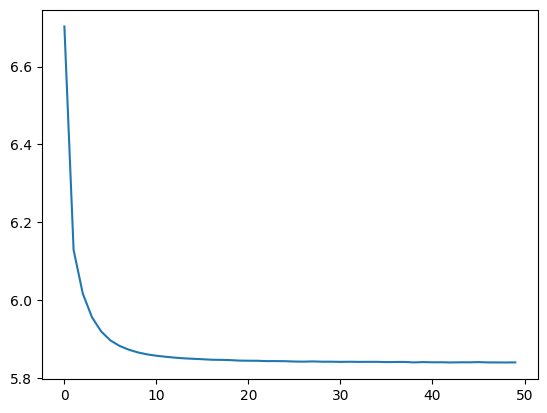

In [45]:
import matplotlib.pyplot as plt
plt.plot(all_losses)

In [46]:
word2vecs = network.expand.weight.cpu().detach().numpy()

In [47]:
from scipy.spatial import distance

In [48]:
w1 = word2vecs[token2id['father']]
w2 = word2vecs[token2id['mother']]

distance.pdist([w1, w2], 'cosine')

array([0.45002099])

In [49]:
w1 = word2vecs[token2id['hate']]
w2 = word2vecs[token2id['speech']]

distance.pdist([w1, w2], 'cosine')

array([0.18259952])

In [57]:
# use model to predict context words given a target word (Skip-gram)
word = 'love'

word_id = token2id[word]

word_vector = torch.tensor([word_id]).to(device)
output = network(word_vector)
probabilities = torch.softmax(output, dim=-1)
output_ids = torch.topk(probabilities, k=10).indices.cpu().detach().numpy().flatten()

# context words and their probabilities
print([(id2token[idx], f"{probabilities[0][idx].item():.2f}") for idx in output_ids])

[('#', '0.21'), ('love', '0.06'), ('i', '0.04'), ('user', '0.03'), ('!', '0.03'), ('@', '0.02'), ('.', '0.01'), ('model', '0.01'), ('you', '0.01'), ('u', '0.01')]


In [63]:
# use model to predict context words given a target word (Skip-gram)
word = 'not'

word_id = token2id[word]

word_vector = torch.tensor([word_id]).to(device)
output = network(word_vector)
probabilities = torch.softmax(output, dim=-1)
output_ids = torch.topk(probabilities, k=10).indices.cpu().detach().numpy().flatten()

# context words and their probabilities
print([(id2token[idx], f"{probabilities[0][idx].item():.2f}") for idx in output_ids])

[('#', '0.05'), ('.', '0.04'), ('user', '0.03'), ('i', '0.02'), (',', '0.02'), ('and', '0.02'), ('you', '0.02'), ('to', '0.02'), ('a', '0.02'), ('the', '0.02')]


In [61]:
# use model to predict context words given a target word (Skip-gram)
word = 'cat'

word_id = token2id[word]

word_vector = torch.tensor([word_id]).to(device)
output = network(word_vector)
probabilities = torch.softmax(output, dim=-1)
output_ids = torch.topk(probabilities, k=10).indices.cpu().detach().numpy().flatten()

# context words and their probabilities
print([(id2token[idx], f"{probabilities[0][idx].item():.2f}") for idx in output_ids])

[('#', '0.24'), ('!', '0.03'), ('.', '0.02'), ('and', '0.01'), ('to', '0.01'), ('?', '0.01'), (':', '0.01'), ('a', '0.01'), (',', '0.01'), ('you', '0.01')]
